# Latent Representation and Exploration of Images Using Variational AutoEncoders
### A presentation by: Arian Amani
### 9913032

## Import libraries

In [1]:
import numpy as np
import cv2
from tensorflow.keras import layers
import tensorflow as tf

from pathlib import Path
from PIL import Image
import pickle

import ipywidgets as widgets

import os
import gdown
from zipfile import ZipFile
import random

from tqdm import tqdm

import matplotlib.pyplot as plt

2023-06-25 20:28:11.584268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-25 20:28:11.584327: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
#@title # Import and preprocess the data
import tensorflow_datasets as tfds
import tensorflow as tf

gcs_base_dir = "gs://celeb_a_dataset/"

celeba_builder = tfds.builder('celeb_a', data_dir=gcs_base_dir, version='2.0.0')
info = celeba_builder.info
# 1. Create the tfrecord files (no-op if already exists)
celeba_builder.download_and_prepare()

In [3]:
#@title Attribute keys
IMAGE_KEY = 'image'
IMAGE_SIZE = 128

In [4]:
def preprocess_img(feature_dict):
  """Normalizes images: `uint8` -> `float32`."""
  image = feature_dict[IMAGE_KEY]
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
  image /= 255.0

  feature_dict[IMAGE_KEY] = image

  return feature_dict

In [5]:
ds_train_all = celeba_builder.as_dataset(split='train', shuffle_files=True)
ds_valid_all = celeba_builder.as_dataset(split='validation', shuffle_files=True)
ds_test_all = celeba_builder.as_dataset(split='test', shuffle_files=True)

In [6]:
get_image = lambda feat_dict: (feat_dict[IMAGE_KEY])

In [7]:
ds_train_all = ds_train_all.map(
    preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train_all.map(get_image)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(10000)
ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [8]:
ds_valid_all = ds_valid_all.map(
    preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid_all.map(get_image)
ds_valid = ds_valid.batch(64)
ds_valid = ds_valid.cache()
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

In [9]:
ds_test_all = ds_test_all.map(
    preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test_all.map(get_image)
ds_test = ds_test.batch(64)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

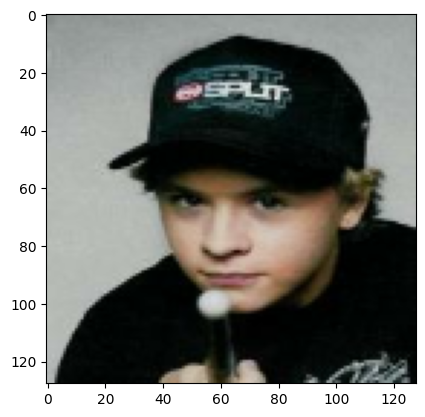

In [ ]:
for example in ds_valid.take(1):
    plt.imshow(example[0])
    break

## This is the most important part!
## Our whole VAE model

In [10]:
class VanillaVAE(tf.keras.Model):
    def __init__(self, image_shape, latent_dim):
        super(VanillaVAE, self).__init__()
        self.image_shape = image_shape
        self.latent_dim = latent_dim
        self.shape_before_flattening = None
        self.encoder = None
        self.decoder = None

        self.train_total_loss_tracker = tf.keras.metrics.Mean(
            name="train_total_loss")
        self.train_reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="train_reconstruction_loss"
        )
        self.train_kl_loss_tracker = tf.keras.metrics.Mean(
            name="train_kl_loss")

        self.test_total_loss_tracker = tf.keras.metrics.Mean(
            name="total_loss")
        self.test_reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.test_kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

        self.build_vae()

    def encoder_block(self, inputs, filters, kernel_size, strides, padding, activation, layer, use_bn=False):
        x = layers.Conv2D(filters, kernel_size, strides,
                          padding, activation=activation, name='Conv2D_'+str(layer))(inputs)
        if use_bn:
            x = layers.BatchNormalization(name='BN_'+str(layer))(x)
        return x

    def decoder_block(self, inputs, filters, kernel_size, strides, padding, activation, layer, use_bn=False):
        x = layers.Conv2DTranspose(
            filters, kernel_size, strides, padding, activation=activation, name='Conv2DTranspose_'+str(layer))(inputs)
        if use_bn:
            x = layers.BatchNormalization(name='BN_'+str(layer))(x)
        return x

    def reparameterize(self, coding):
        mu, log_var = coding
        epsilon = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(log_var * .5) * epsilon

    def build_encoder(self):
        inputs = layers.Input(shape=self.image_shape, name='Encoder_Input')
        x = self.encoder_block(inputs=inputs, filters=32, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=1, use_bn=True)
        x = self.encoder_block(inputs=x, filters=64, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=2, use_bn=True)
        x = self.encoder_block(inputs=x, filters=128, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=3, use_bn=True)
        x = self.encoder_block(inputs=x, filters=256, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=4, use_bn=True)
        x = self.encoder_block(inputs=x, filters=512, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=5, use_bn=True)
        self.shape_before_flattening = tf.keras.backend.int_shape(x)[1:]
        x = layers.Flatten(name='Flatten')(x)
        x = layers.Dense(512, activation='relu', name='Dense_Layer_6')(x)
        mu = layers.Dense(self.latent_dim, name='Dense_MU')(x)
        log_var = layers.Dense(self.latent_dim, name='Dense_Log_Var',
                               kernel_initializer=tf.keras.initializers.RandomUniform(
                                   minval=-0.08, maxval=0.08, seed=None)
                               )(x)
        z = layers.Lambda(self.reparameterize, output_shape=(
            self.latent_dim,), name='Code')([mu, log_var])

        self.encoder = tf.keras.Model(inputs, [mu, log_var, z], name='encoder')

    def build_decoder(self):
        inputs = layers.Input(shape=(self.latent_dim,), name='Decoder_Input')
        x = layers.Dense(512, activation='relu', name='Dense_Layer_7')(inputs)
        x = layers.Dense(np.prod(self.shape_before_flattening),
                         activation='relu', name='Dense_Layer_8')(x)
        x = layers.Reshape(self.shape_before_flattening,
                           name='Reshape_Layer')(x)
        x = self.decoder_block(inputs=x, filters=256, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=9, use_bn=True)
        x = self.decoder_block(inputs=x, filters=128, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=10, use_bn=True)
        x = self.decoder_block(inputs=x, filters=64, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=11, use_bn=True)
        x = self.decoder_block(inputs=x, filters=32, kernel_size=3,
                               strides=2, padding='same', activation='relu', layer=12, use_bn=True)
        x = self.decoder_block(inputs=x, filters=3, kernel_size=3,
                               strides=2, padding='same', activation='tanh', layer=13, use_bn=False)
        self.decoder = tf.keras.Model(inputs, x, name='decoder')

    def build_vae(self):
        self.build_encoder()
        self.build_decoder()

    @property
    def metrics(self):
        return [
            self.train_total_loss_tracker,
            self.train_reconstruction_loss_tracker,
            self.train_kl_loss_tracker,
            self.test_total_loss_tracker,
            self.train_reconstruction_loss_tracker,
            self.test_kl_loss_tracker
        ]

    def compute_loss(self, inputs, outputs, mu, log_var):
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(tf.square(inputs - outputs), axis=(1, 2, 3)))
        # reconstruction_loss *= 0.1  # reconstruction_loss_factor

        kl_loss = -0.5 * (1 + log_var - tf.exp(log_var) - tf.square(mu))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        kl_loss *= 30  # kl_loss_factor

        total_loss = kl_loss + reconstruction_loss
        return total_loss, reconstruction_loss, kl_loss

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mu, log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            total_loss, reconstruction_loss, kl_loss = self.compute_loss(
                data, reconstruction, mu, log_var)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.train_total_loss_tracker.update_state(total_loss)
        self.train_reconstruction_loss_tracker.update_state(
            reconstruction_loss)
        self.train_kl_loss_tracker.update_state(kl_loss)

        return {
            'train_total_loss': self.train_total_loss_tracker.result(),
            'train_reconstruction_loss': self.train_reconstruction_loss_tracker.result(),
            'train_kl_loss': self.train_kl_loss_tracker.result()
        }

    def test_step(self, data):
        mu, log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        total_loss, reconstruction_loss, kl_loss = self.compute_loss(
            data, reconstruction, mu, log_var)
        self.test_total_loss_tracker.update_state(total_loss)
        self.test_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.test_kl_loss_tracker.update_state(kl_loss)

        return {
            'total_loss': self.test_total_loss_tracker.result(),
            'reconstruction_loss': self.test_reconstruction_loss_tracker.result(),
            'kl_loss': self.test_kl_loss_tracker.result()
        }

    def sample(self, count=1, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(count, self.latent_dim))
        return self.decoder(eps)

    def reconstruct(self, data):
        mu, log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        return reconstruction

## Let's create and compile our model and see the architecture

In [11]:
vae = VanillaVAE(image_shape=(128, 128, 3), latent_dim=128)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

In [ ]:
# Encoder architecture
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder_Input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv2D_1 (Conv2D)              (None, 64, 64, 32)   896         ['Encoder_Input[0][0]']          
                                                                                                  
 BN_1 (BatchNormalization)      (None, 64, 64, 32)   128         ['Conv2D_1[0][0]']               
                                                                                                  
 Conv2D_2 (Conv2D)              (None, 32, 32, 64)   18496       ['BN_1[0][0]']             

In [ ]:
# Decoder architecture
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Decoder_Input (InputLayer)  [(None, 128)]             0         
                                                                 
 Dense_Layer_7 (Dense)       (None, 512)               66048     
                                                                 
 Dense_Layer_8 (Dense)       (None, 8192)              4202496   
                                                                 
 Reshape_Layer (Reshape)     (None, 4, 4, 512)         0         
                                                                 
 Conv2DTranspose_9 (Conv2DTr  (None, 8, 8, 256)        1179904   
 anspose)                                                        
                                                                 
 BN_9 (BatchNormalization)   (None, 8, 8, 256)         1024      
                                                           

## TRAIN :))

In [ ]:
with tf.device('/device:GPU:0'):
    history = vae.fit(ds_train, epochs=10, batch_size=64, shuffle=True, validation_data=ds_valid)

## Always save your trained model

In [ ]:
vae.encoder.save('vae_encoder')
vae.decoder.save('vae_decoder')

In [12]:
!git clone https://github.com/ArianAmani/TheseThingsDoNotExist/

Cloning into 'TheseThingsDoNotExist'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 65 (delta 6), reused 17 (delta 3), pack-reused 36
Unpacking objects: 100% (65/65), 42.25 MiB | 5.98 MiB/s, done.


In [13]:
# Run to load the weights back in to the model
vae.encoder.load_weights('TheseThingsDoNotExist/VAEs/Vanilla_VAE/checkpoint_20_epochs/vae_encoder/variables/variables')
vae.decoder.load_weights('TheseThingsDoNotExist/VAEs/Vanilla_VAE/checkpoint_20_epochs/vae_decoder/variables/variables')

## Let's see how it turned out...


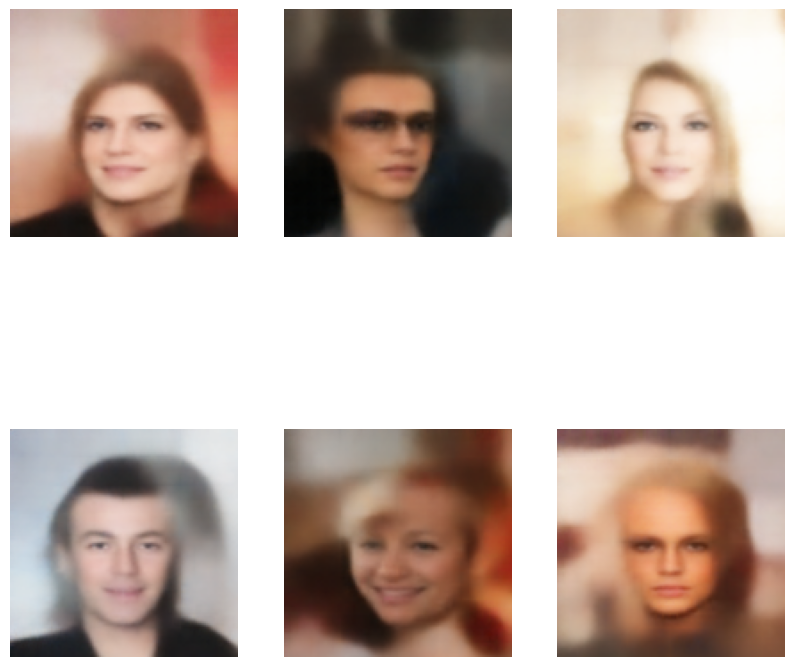

In [ ]:
# Generate 6 faces that do not exist
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10., 10.))

for ax in axes.flat:
    sample = vae.sample(eps=tf.expand_dims(tf.random.normal(shape=(128,)), 0))
    img= (sample.numpy() * 255).astype("int32")[0]
    ax.imshow(img)
    ax.axis('off')

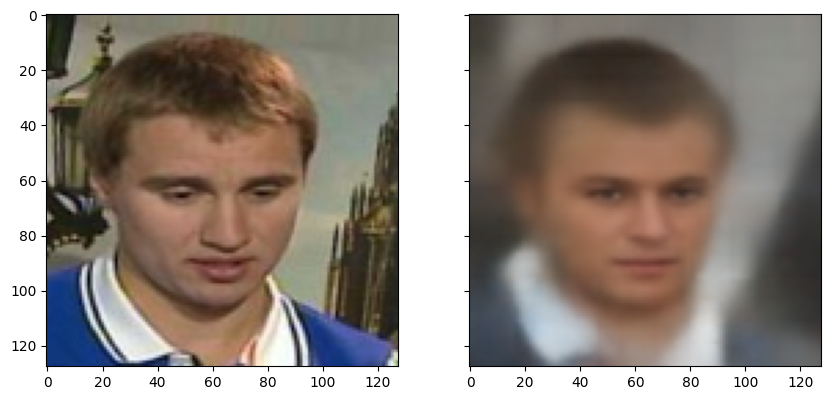

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10., 10.))

for example in ds_test.take(1):
    axes[0].imshow(example[5])
    axes[1].imshow(tf.squeeze(vae.reconstruct(tf.expand_dims(example[5], 0)), 0))
    break

In [14]:
import gc
gc.collect()

624

In [15]:
#@title # Let's play with the latent space
SMILE_KEY = "Smiling"
BALD_KEY = "Bald"
BLACK_HAIR_KEY = "Black_Hair"
BLOND_HAIR_KEY = "Blond_Hair"
BROWN_HAIR_KEY = "Brown_Hair"
GLASSES_KEY = "Eyeglasses"
MALE_KEY = "Male"

attributes = [SMILE_KEY, BALD_KEY, GLASSES_KEY, MALE_KEY]
BS = 512

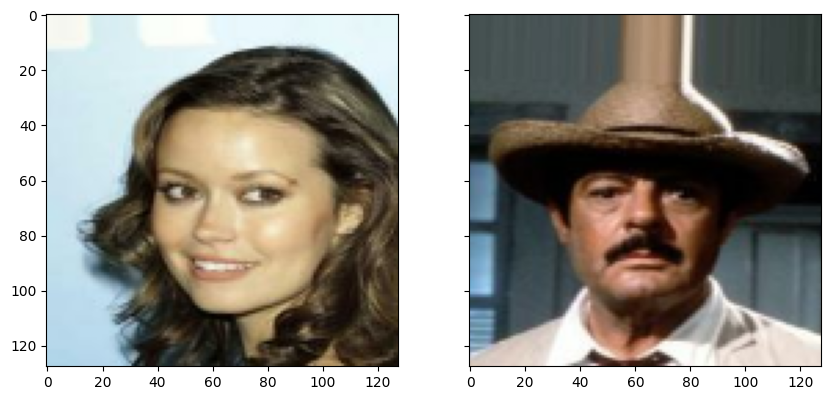

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10., 10.))

for smile, no_smile in zip(smiling_ds.take(1), not_smiling_ds.take(1)):
    axes[0].imshow(smile[5])
    axes[1].imshow(no_smile[5])
    break

In [16]:
def get_attr(batch, attr_key):
    imgs = batch[IMAGE_KEY]
    attr = batch['attributes'][attr_key]
    return imgs[attr]

def get_not_attr(batch, attr_key):
    imgs = batch[IMAGE_KEY]
    attr = batch['attributes'][attr_key]
    return imgs[~attr]

In [17]:
def get_attribute_latent(attr_key):
    # attr_data = celeba_builder.as_dataset(split=tfds.Split.ALL)
    with tf.device("/GPU:0"):
        # attr_ds = attr_data.map(preprocess_img).batch(512).map(lambda x: get_attr(x, attr_key))
        # no_attr_ds = attr_data.map(preprocess_img).batch(512).map(lambda x: get_not_attr(x, attr_key))
        attr_ds = ds_train_all.batch(512).map(lambda x: get_attr(x, attr_key))
        no_attr_ds = ds_train_all.batch(512).map(lambda x: get_not_attr(x, attr_key))

        attr_latents = []
        non_attr_latents = []
        for attr in tqdm(attr_ds):
            attr_latents.append(vae.encoder(attr)[2])
        tf.compat.v1.reset_default_graph()
        tf.keras.backend.clear_session()
        gc.collect()

        for no_attr in tqdm(no_attr_ds):
            non_attr_latents.append(vae.encoder(no_attr)[2])
        tf.compat.v1.reset_default_graph()
        tf.keras.backend.clear_session()
        gc.collect()


    attr = tf.concat(attr_latents, 0).numpy().mean(0)
    no_attr = tf.concat(non_attr_latents, 0).numpy().mean(0)

    attr_vector = attr - no_attr

    return attr_vector

In [18]:
attr_vectors = {}
for attribute in attributes:
    attr_vectors[attribute] = get_attribute_latent(attribute)

100%|██████████| 318/318 [04:22<00:00,  1.21it/s]


In [22]:
with open('attribute_vectoor_dict.pkl', 'wb') as outp:
    pickle.dump(attr_vectors, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
file_pi = open('attribute_vectoor_dict.pkl', 'w')
pickle.dump(object_pi, file_pi)

In [23]:
def linear_interpolation(latent1, latent2, alpha=0.5):
    return alpha * latent1 + (1 - alpha) * latent2

In [24]:
def add_attribute(latent, attribute, alpha=1):
    return latent + alpha * attribute

In [25]:
def get_image_from_latent(latent):
    return tf.squeeze(vae.decoder(latent), 0)

In [26]:
def get_latent_from_image(image):
    latent = vae.encoder(tf.expand_dims(image, 0))[2]
    return latent

In [51]:
fps = 20
results_size = 400

In [52]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def make_latent_interp_animation(code1, code2, img1, img2, num_interps, save_name='latent_space_traversal.gif'):
    img1 = img1.resize((results_size, results_size))
    img2 = img2.resize((results_size, results_size))

    step_size = 1.0/num_interps

    all_imgs = []

    amounts = np.arange(0, 1, step_size)

    for alpha in tqdm(amounts):
        interpolated_latent_code = linear_interpolation(code1, code2, alpha)
        images = get_image_from_latent(interpolated_latent_code)
        interp_latent_image = tf.keras.utils.array_to_img(images).resize((results_size, results_size))
        frame = get_concat_h(img1, interp_latent_image)
        frame = get_concat_h(frame, img2)
        all_imgs.append(frame)

    all_imgs[0].save(save_name, save_all=True, append_images=all_imgs[1:], duration=1000/fps, loop=0)

In [60]:
test_batch = next(iter(ds_test.take(1)))
starting = random.randint(0, len(test_batch)-1)

image1 = test_batch[starting]
image2 = test_batch[starting+1]
latent1 = get_latent_from_image(image1)
latent2 = get_latent_from_image(image2)
image1 = tf.keras.utils.array_to_img(image1)
image2 = tf.keras.utils.array_to_img(image2)

In [61]:
make_latent_interp_animation(latent1, latent2, image1, image2, num_interps=200, save_name='test.gif')

100%|██████████| 200/200 [00:03<00:00, 54.67it/s]


In [68]:
def make_latent_control_animation(image, feature, start_amount, end_amount, step_size, name='person'):

    all_imgs = []

    latent = get_latent_from_image(image)
    amounts = np.linspace(start_amount, end_amount, int(abs(end_amount-start_amount)/step_size))

    image = tf.keras.utils.array_to_img(image).resize((results_size, results_size))
    for amount_to_move in tqdm(amounts):
        modified_latent_code = np.array(latent)
        modified_latent_code += attr_vectors[feature]*amount_to_move
        images = get_image_from_latent(modified_latent_code)
        latent_img = tf.keras.utils.array_to_img(images).resize((results_size, results_size))
        all_imgs.append(get_concat_h(image, latent_img))

    save_name = '{0}_{1}.gif'.format(name, feature)
    all_imgs[0].save(save_name, save_all=True, append_images=all_imgs[1:], duration=1000/fps, loop=0)

In [69]:
image1 = test_batch[starting]

In [95]:
make_latent_control_animation(image1, feature='Smiling', start_amount=-3, end_amount=3, step_size=0.05, name='test_attr')

100%|██████████| 120/120 [00:02<00:00, 56.26it/s]


In [ ]:
def multiple_attrs(image, features, alphas):
    latent = get_latent_from_image(image)
    for i, feature in enumerate(features):
        latent += attr_vectors[feature] * alphas[i]

    return get_image_from_latent(latent)

In [71]:
tf.keras.backend.clear_session()
gc.collect()
tf.compat.v1.reset_default_graph()

with tf.device("/GPU:0"):
    tf.keras.backend.clear_session()
    gc.collect()
    tf.compat.v1.reset_default_graph()

# device = cuda.get_current_device()
# device.reset()

In [73]:
def plot_attribute_added(attr, alpha=1):
    fig, axes = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(15., 6))

    test_batch = next(iter(ds_test.take(1)))
    starting = random.randint(0, len(test_batch) - 5)
    for i in range(5):
        axes[0][i].imshow(test_batch[starting + i])
        latent = vae.encoder(tf.expand_dims(test_batch[starting + i], 0))[2]

        axes[1][i].imshow(tf.squeeze(vae.decoder(latent), 0))
        axes[2][i].imshow(tf.squeeze(vae.decoder(latent + attr*alpha), 0))

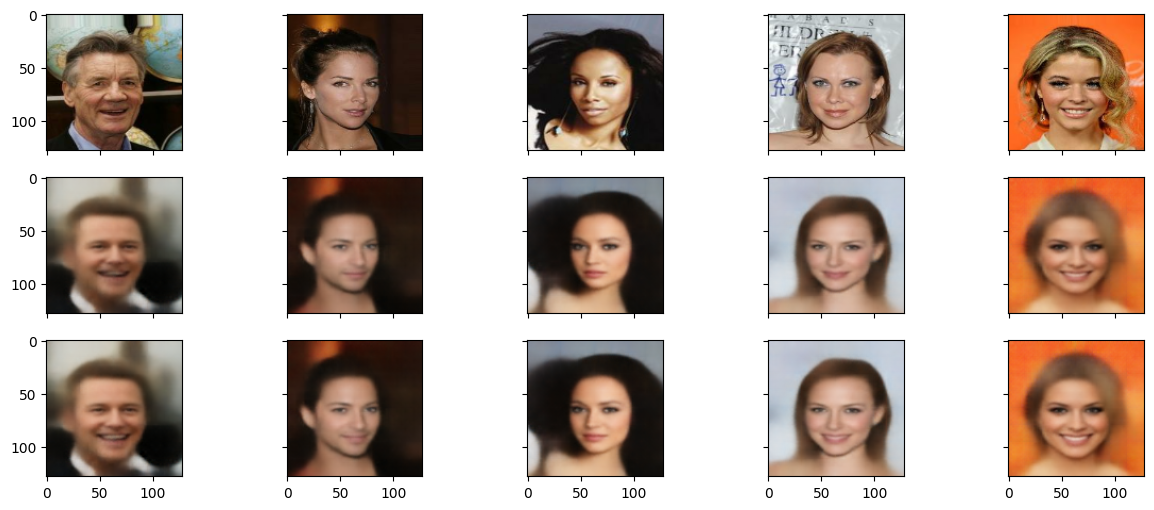

In [77]:
plot_attribute_added(attr_vectors['Smiling'], .5)

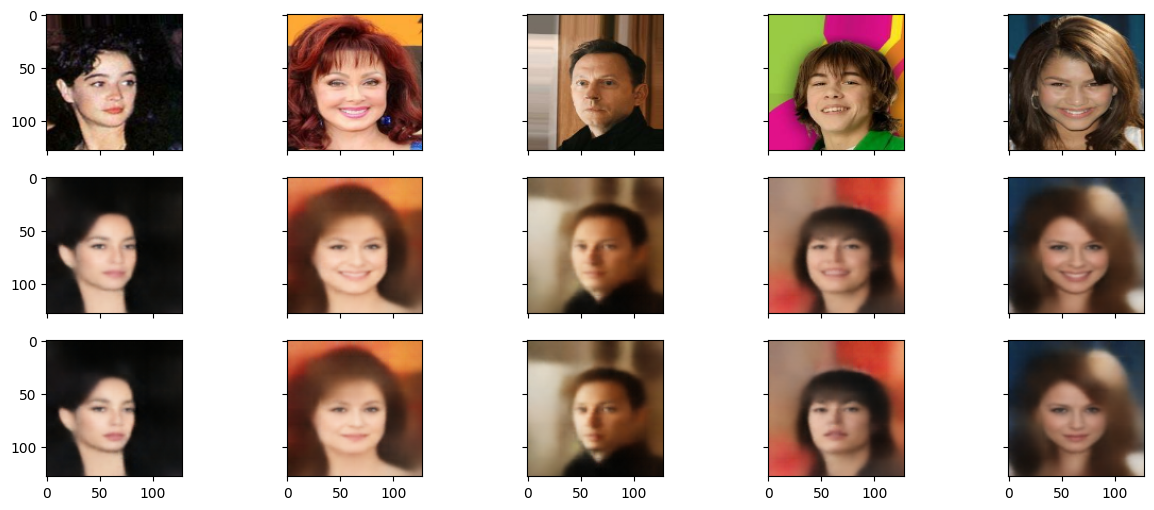

In [78]:
plot_attribute_added(attr_vectors['Smiling'], -1)

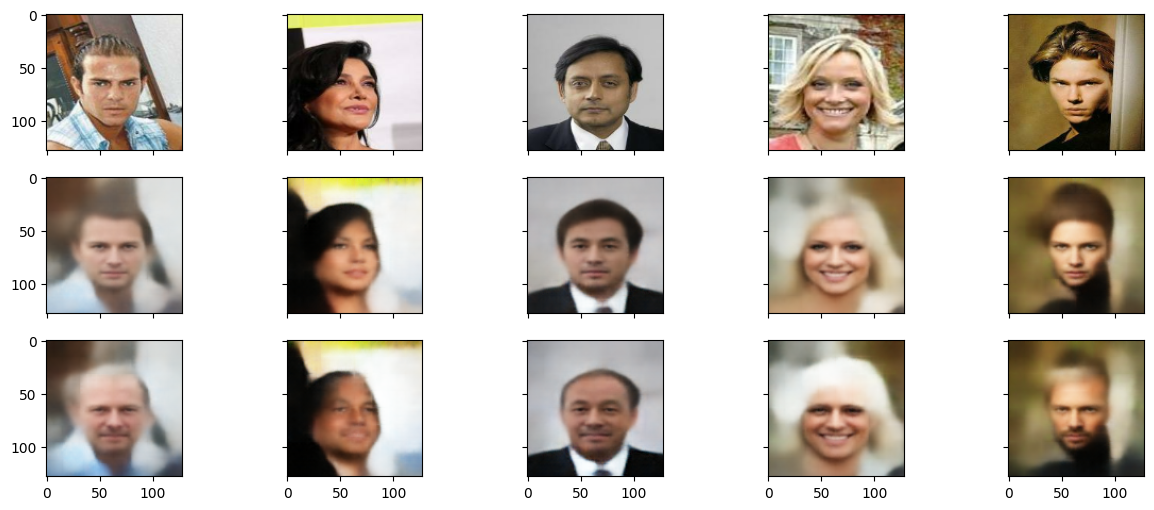

In [90]:
plot_attribute_added(attr_vectors['Bald'], 1.5)

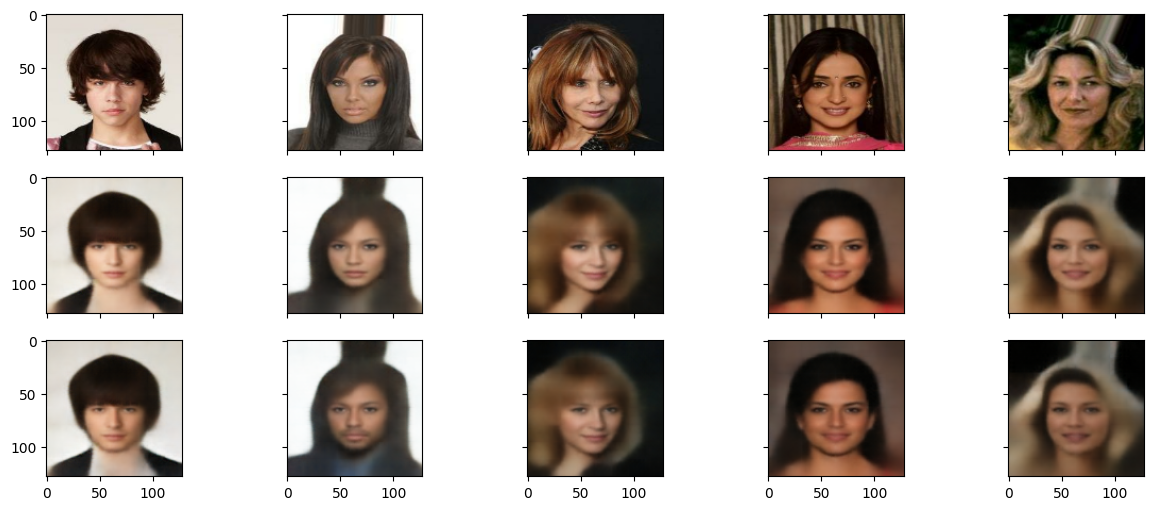

In [83]:
plot_attribute_added(attr_vectors['Male'], 1)

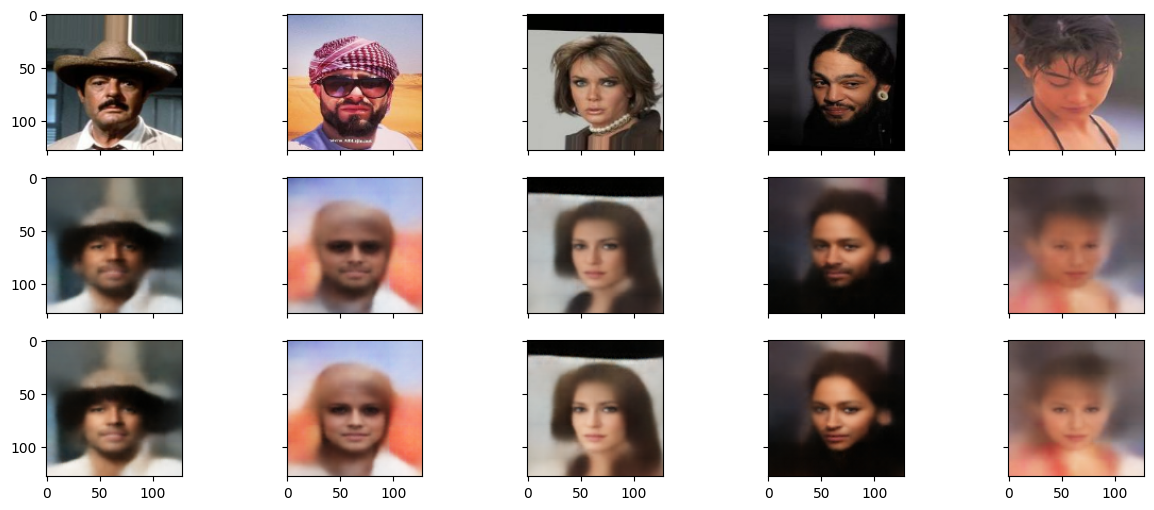

In [88]:
plot_attribute_added(attr_vectors['Male'], -1)

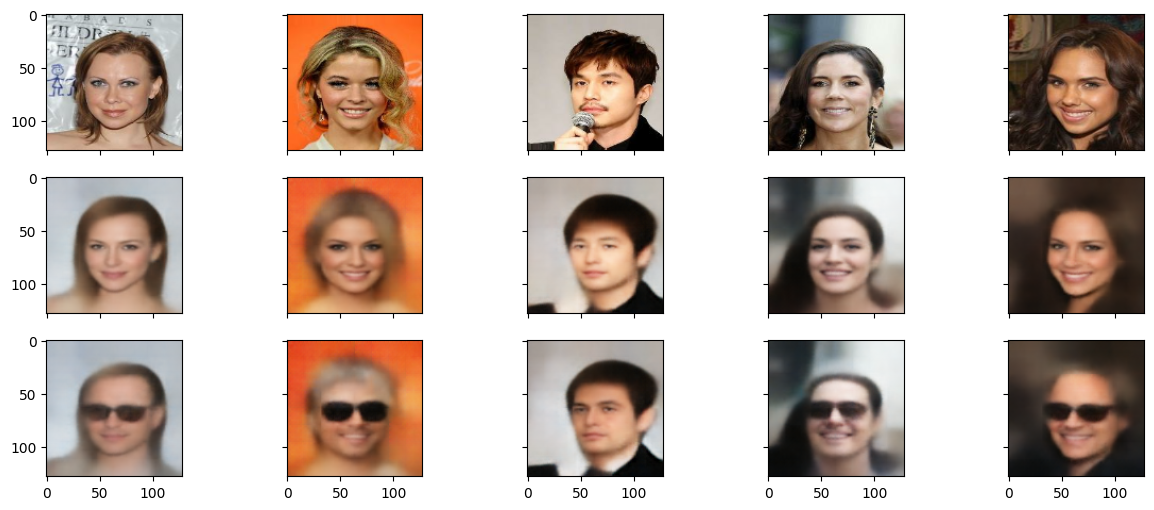

In [93]:
plot_attribute_added(attr_vectors['Eyeglasses'], 2)

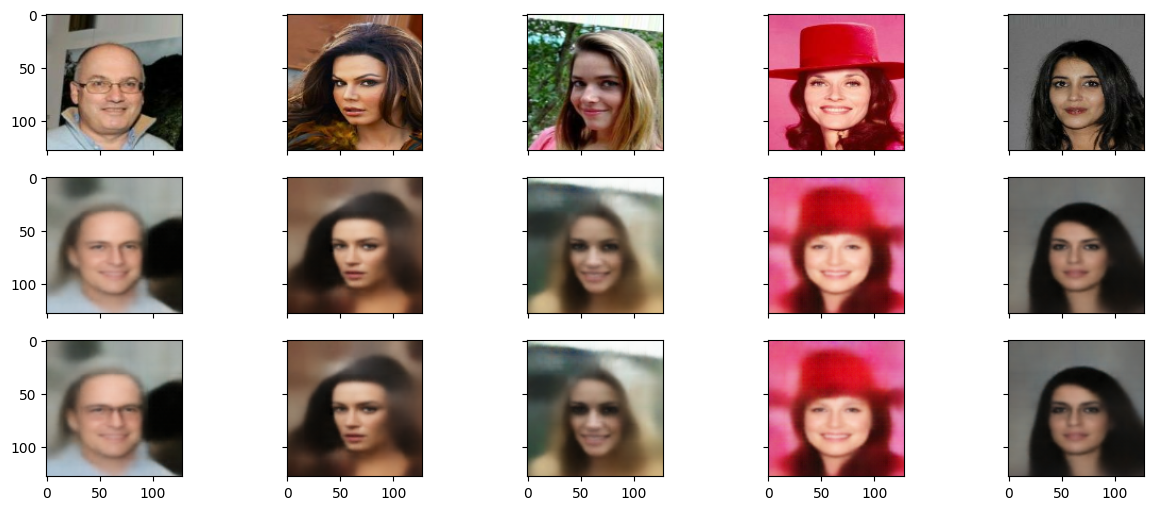

In [98]:
plot_attribute_added(attr_vectors['Eyeglasses'], 2.5)

<img src="./gifs/gifs/test_attr_Male.gif" width="750" align="center">

## Bald
![image](gifs/gifs/Bald1_Bald.gif 'image')


![image](gifs/gifs/Bald2_Bald.gif 'image')


![image](gifs/gifs/Bald3_Bald.gif 'image')

## Eyeglasses
![image](gifs/gifs/Eyeglasses1_Eyeglasses.gif 'image')

## Male
![image](gifs/gifs/Male1_Male.gif 'image')


![image](gifs/gifs/Male2_Male.gif 'image')


![image](gifs/gifs/Male3_Male.gif 'image')

## Smile
![image](gifs/gifs/Smile1_Smiling.gif 'image')


![image](gifs/gifs/Smile2_Smiling.gif 'image')


![image](gifs/gifs/Smile3_Smiling.gif 'image')

## Interpolation
![image](gifs/gifs/interpolation.gif 'image')


![image](gifs/gifs/interpolation1.gif 'image')


![image](gifs/gifs/interpolation2.gif 'image')


![image](gifs/gifs/test.gif 'image')